<h1> Analysis of meteorogical and air quality data from Helsinki area </h1>
<p> Author: Tatu Anttila </p>
<p> This exercise demonstrate some of the features of data analysis using Python + relevant packages. The analysed data consists of automated measurements carried out by <a href="https://en.ilmatieteenlaitos.fi/">Finnish Meteorological Institute</a> (FMI) in Helsinki. The data covers the year 2022.</p>
<p> The goal of the exercise is to explore connections between variables related to meteorology and those related to air quality. In particular, the following question is addressed: can variables related to weather tell us something about air quality? The question is interesting, because if so, weather predictions could be used to predict air quality. This would help persons belonging to risk groups (e.g. those suffering from severe asthma) to plan their day according to the forecasts (for example, preparing to wear mask outdoors).<p>

*NOTE:*  The notebook was executed with combination of Visual Studio Code + Python 3.10 + Jupyter notebook under Windows 10.
It may NOT run work with Google Colab or with Anacondas + Jupyter due to memory issues.
Also, at the moment (as of 23.4.2023) it does NOT run under Python 3.11 due to package dependencies (tslearn package).   

The following key Python packages are used in the exercise:  
- <a href="https://pandas.pydata.org/"> Pandas</a>: Used for storing and manipulating data using <a href= "https://pandas.pydata.org/docs/user_guide/dsintro.html#dataframe"> dataframes</a>. 
- <a href="https://scipy.org/"> SciPy</a> : Library for scientific computing. 
- <a href="https://matplotlib.org/"> Matplotlib </a> : Library for data visualisation. 
- <a href="https://seaborn.pydata.org/"> seaborn </a> : Data visualisation library based on Matplotlib.
- <a href= "https://scikit-learn.org/stable/index.html"> sci-kit learn </a> : Machine learning toolbox.

- <a href= "https://tslearn.readthedocs.io/en/stable/"> tslearn </a> : Machine learning tools for the analysis of time series.

The following code snippet contains the needed Python packages used in this work.  

*NOTE:* some of the packages may need to be installed to run the whole notebook, in particular: fmiopendata and tslearn. 

In [1]:
import datetime as dt
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np

# !pip install tslearn # # install package, if needed
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax

from sklearn.utils import resample
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# !pip install fmiopendata # install package, if needed
from fmiopendata.wfs import download_stored_query  


C:\Users\tatu2\AppData\Roaming\Python\Python310\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Data analysis workflow
According to [this blog text by Philip Guo](https://cacm.acm.org/blogs/blog-cacm/169199-data-science-workflow-overview-and-challenges/fulltext) data analysis workflow can be illustrated as follows:

!["data science workflow"](https://cacm.acm.org/system/assets/0001/3678/rp-overview.jpg)

The presentation of this exercise follows loosely the steps shown in the figure. 

## 1. Data acquisition
<p>We start with the data acquisition. The source of analysed data is <a href="https://en.ilmatieteenlaitos.fi/open-data">open data provided by FMI</a>. 
In particular, FMI open data includes measurements of air quality and weather from observation stations across Finland. Our focus is partially on air quality, and hence we narrow down to observation stations in Helsinki area (urban and relatively polluted area). After some browsing of measurement station network data by making queries using the Python interface described below, we pick two observations stations: "Helsinki Kallio 2" (air quality measurements) and "Helsinki Kumpula" (meteorological measurements). These two sites are within a few kilometers of each other, and hence the atmospheric conditions can be considered quite similar in both of the sites. </p>
<p>The data was acquired using publicly available <a href="https://github.com/pnuu/fmiopendataa">Python interface</a>. The codes below retrieve all the available data from the two selected stations for year 2022 and store them to Pandas dataframes. Note that the interface allows for retrieving 168 hours of data at maximum with a single query. To work around this limitation, a series of consequtive queries are made using loop structure. </p> <p>Weather and air quality measurements have time resolution of 10 and 60 minutes, respectively. Here we retrieve the weather data using time interval of 60 minutes, however, to match with the time resolution of air quality measurements.</p>  

Note: we store the resulting data sets in Pickle format as files 'df_raw_aq.pkl' and 'df_raw_aq.pkl'. These files are included in the returned .zip file. Hence one may skip the following steps, and move directly to [section](##Cleaning/reformatting-of-data) in below.

The following two functions will retrieve data from the two chosen observation stations (meteorology and air quality) within a given time interval: 

In [2]:
def get_weather_data(start_time,time_int): 

    # weather observation station:
    obs_station_weather= "Helsinki Kumpula"

    # time interval over which data is retrieved
    end_time = start_time + dt.timedelta(hours=time_int) 
    # Convert times to properly formatted strings
    start_time = start_time.isoformat(timespec="seconds") + "Z"
    end_time = end_time.isoformat(timespec="seconds") + "Z"

    # Retrieve meteorological data:
    # NOTE: here 60 min averaging interval is used, even though measurement resolution is 10 min for all variables except 'r_1h'.
    #       This was chosen to match measurement interval in air quality data.
    obs_weather = download_stored_query("fmi::observations::weather::multipointcoverage",
                                args=["bbox=24.9,60.1,25.1,60.21",
                                    "starttime=" + start_time,
                                    "endtime=" + end_time,  
                                    "timestep=60", # match time resolution with air quality measurements
                                    "timeseries=True"])

    # names of retrieved variables:           
    var_weather= list((obs_weather.data[obs_station_weather].keys()))
    var_weather= var_weather[1:] # drop time variable from list
    # corresponding columns in Pandas table:              
    cols_weather= list((obs_weather.data[obs_station_weather].keys()))  
                                            
    # store time data for weather: 
    times_weather = obs_weather.data[obs_station_weather]['times']
    n_weather= len(times_weather) # number of data points   

    # store measurement data to Pandas dataframe: 
    df_weather = pd.DataFrame(columns= cols_weather)
    df_weather['times']= times_weather

    idx= 1 # index variable used loop below
    for var in var_weather:
        temp_row= []   
        for i in range(n_weather):            
                temp_row.append(obs_weather.data[obs_station_weather][var]["values"][i])   
        df_weather[cols_weather[idx]]= temp_row
        idx= idx+1
    return(df_weather)

In [3]:
def get_air_quality_data(start_time,time_int):      

      # Air quality observation station:
      obs_station_aq= 'Helsinki Kallio 2'

      # Time period over which data is retrieved
      end_time = start_time + dt.timedelta(hours=time_int) 

      # Convert times to properly formatted strings
      start_time = start_time.isoformat(timespec="seconds") + "Z"
      end_time = end_time.isoformat(timespec="seconds") + "Z"

      # Retrieve air quality data:
      obs_aq = download_stored_query("urban::observations::airquality::hourly::multipointcoverage",
                              args=["bbox=24.9,60.1,25.1,60.21",    
                                    "starttime=" + start_time,
                                    "endtime=" + end_time,  
                                    "timeseries=True"])

      # names of retrieved variables:
      var_aq= list((obs_aq.data[obs_station_aq].keys()))
      var_aq= var_aq[1:]  # drop time variable from list   
                   
      # corresponding columns in Pandas table:  
      cols_aq= list((obs_aq.data[obs_station_aq].keys()))
                                      
      # store time variable: 
      times_aq = obs_aq.data[obs_station_aq]['times']
      n_aq= len(times_aq) # number of data points

      # store air quality data in Pandas dataframe: 
      df_aq = pd.DataFrame(columns= cols_aq)
      df_aq['times']= times_aq # time variable

      idx= 1 # index variable used in loop below
      for var in var_aq:
            temp_row= []   
            for i in range(n_aq):            
                  temp_row.append(obs_aq.data[obs_station_aq][var]["values"][i])   
            df_aq[cols_aq[idx]]= temp_row
            idx= idx+1
      return(df_aq)

The following script retrieves meteorological and air quality data for the year 2022 and store the results in pickle format. 

This may take a while, even one or two hours (using Colab), so please be patient.

In [4]:
# Collect data to dataframes for year 2022 and store them using Pickle.
# NOTE: fmiopendata interface allows queries covering time interval of 168h at maximum.
#       Hence data is retrieved one day at time (see loop structure below). 
yy= 2022 # selected year
no_days= [31,28,31,30,31,30,31,31,30,31,30,31] # number days/month in 2022

# time interval (months) over which data is retrieved:
mm_start=1
mm_end=12

# interval for a single query (in h) 
# note: using time interval of 24 h would lead to overlap between subsequent queries
time_int= 23 + 59/60 
dfs_created = False # are dataframes already created?

for month in range(mm_start, mm_end+1,1):
    for day in range(1,no_days[month-1]+1,1):
        cur_time= dt.datetime(yy, month, day)
        if (not dfs_created): # initialize dataframe
            df_raw_met= get_weather_data(cur_time,time_int)   
            df_raw_aq= get_air_quality_data(cur_time,time_int)
            dfs_created= True
        else: # insert data to the dataframe
           df_temp= get_weather_data(cur_time,time_int)   
           df_raw_met= pd.concat([df_raw_met, df_temp], axis= 0)
           df_temp= get_air_quality_data(cur_time,time_int)
           df_raw_aq= pd.concat([df_raw_aq, df_temp], axis= 0)

# save resulting dataframes in pickle format:
df_raw_aq.to_pickle("./df_raw_aq.pkl")  
df_raw_met.to_pickle("./df_raw_met.pkl")

Let's check first the dataframe timestamps. Both time series should have constant time difference of one hour between adjacent entries. Also, both series should have matching timestamps. 

In [5]:
t_diff = (df_raw_aq["times"].diff()).dt.total_seconds()/3600 # difference in hours
print(t_diff.unique())

t_diff = (df_raw_met["times"].diff()).dt.total_seconds()/3600 # difference in hours
print(t_diff.unique())

t_diff= (df_raw_met["times"] - df_raw_aq["times"])
print(t_diff.unique())

[nan  1.]
[nan  1.]
<TimedeltaArray>
['0 days']
Length: 1, dtype: timedelta64[ns]


The results shown above verify that the timestamps are valid and consistent.

## Cleaning/reformatting of data

In general, cleaning/reformatting the data involves several [tasks](https://www.kaggle.com/learn/data-cleaning), such as: 
- handling missing values
- scaling and renormalization of numerical variables
- parsing dates
- dealing with character encodings
- fixing typos in data

Let's take a first look at the data and the features:

In [6]:
# Meteorological data:
df_raw_met= pd.read_pickle("./df_raw_met.pkl")  
# Air quality data: 
df_raw_aq= pd.read_pickle("./df_raw_aq.pkl")  
# check the retrieved dataframes:
df_raw_met.info()
df_raw_aq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 23
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   times     8760 non-null   datetime64[ns]
 1   t2m       8734 non-null   float64       
 2   ws_10min  8637 non-null   float64       
 3   wg_10min  8637 non-null   float64       
 4   wd_10min  8637 non-null   float64       
 5   rh        8722 non-null   float64       
 6   td        8722 non-null   float64       
 7   r_1h      8718 non-null   float64       
 8   ri_10min  8722 non-null   float64       
 9   snow_aws  8718 non-null   float64       
 10  p_sea     8722 non-null   float64       
 11  vis       8722 non-null   float64       
 12  n_man     8722 non-null   float64       
 13  wawa      8722 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 23
Data columns (total 11 columns):
 #  

The meteorogical data consists of following variables:

| Variable (meteorology) | Description                                  |
| :--------------------- | :------------------------------------------- |
| times                  | local time (datetime format)                 |
| t2m                    | temperature (in C)                           |
| ws_10min               | wind speed (in m/s)                          |
| wg_10min               | gust wind speed (in m/s)                     |
| wd_10min               | wind direction (in degrees)                  |
| rh                     | relative humidity (in %)                     |
| td                     | dew point (in C), see below                  |
| r_1h                   | precipation (accumulated over 1 hour, in mm) |
| ri_10min               | rain intensity (in mm/h)                     |
| snow_aws               | snow depth (in cm)                           |
| p_sea                  | air pressure (in hPa)                        |
| vis                    | visibility (in m)                            |
| n_man                  | cloud cover (in oktas, see below)            |
| wawa                   | ??? (dimensionless)                          |

For definition of dew point, see: https://en.wikipedia.org/wiki/Dew_point  
For oktas, see: https://en.wikipedia.org/wiki/Okta

The air quality data consists of following variables:

| Variable (air quality) | Description                                                          |
| :--------------------- | :------------------------------------------------------------------- |
| SO2_PT1H_avg           | concentration of sulfur dioxide (in µg/m3)                           |
| NO_PT1H_avg            | concentration of nitrogen monoxide (in µg/m3)                        |
| NO2_PT1H_avg           | concentration of nitrogen dioxide (µg/m3)                            |
| O3_PT1H_avg            | concentration of ozone (in µg/m3)                                    |
| TRSC_PT1H_avg          | concentration of total reduced sulfuric compounds, TRSC (in µgS/m3)  |
| CO_PT1H_avg            | concentration of carbon monoxide (in µg/m3)                          |
| PM10_PT1H_avg          | concentration of particulate matter below 10um in size (in µg/m3)    |
| PM25_PT1H_avg          | concentration of particulate matter below 2.5um in size (in µg/m3)   |
| AQINDEX_PT1H_avg       | air quality index, see below                                         |
| QBCPM25_PT1H_AVG       | concentration of black carbon in PM2.5 particulate matter (in µg/m3) | 

For air quality index, see: https://en.ilmatieteenlaitos.fi/air-quality-index



It can be seen that no data is available for 'CO_PT1H_avg' and 'TRSC_PT1H_avg' variables, i.e. the observation station was not measuring carbon dioxide or TRSC concentrations during 2022. Hence these two variables can removed from the dataframe:

In [7]:
df_raw_aq.drop(columns=['TRSC_PT1H_avg', 'CO_PT1H_avg'], inplace= True, errors='ignore')

No information on the meteorological variable 'wawa' could be found in FMI open data documentation (its definition, for example). Because of the lack of information, we remove the variable: 

In [8]:
df_raw_met.drop(columns=['wawa'], inplace= True, errors='ignore')

Also, there are some gaps in the data, even though only 3% of the measurements are missing at most over all considered variables. Our aim is to replace missing values with interpolated values. Because the time resolution of data is relatively high, this should work at least in case where no long, continous gaps exist in the time series (e.g. due to instrument malfunction/maintenance). To check this, we illustrate periods with missing data as follows.

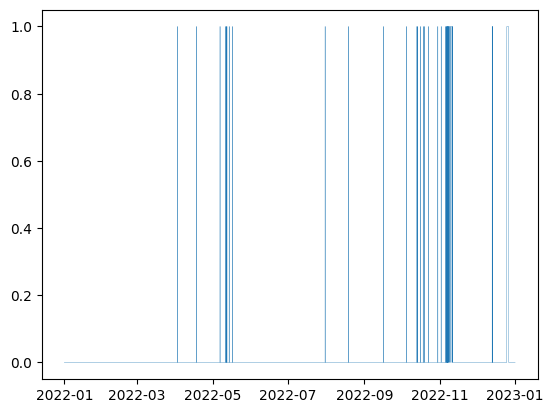

In [9]:
# meteorological data:
# true/false value is assigned for each row (depending if no NaN values are found in the row, or at least one):
temp= df_raw_met.isnull().any(axis=1)
# code true and false to 1 and 0, respectively:
temp[temp== True] = 1
temp[temp== False] = 0
plt.plot(df_raw_met['times'], temp, linewidth=0.25)

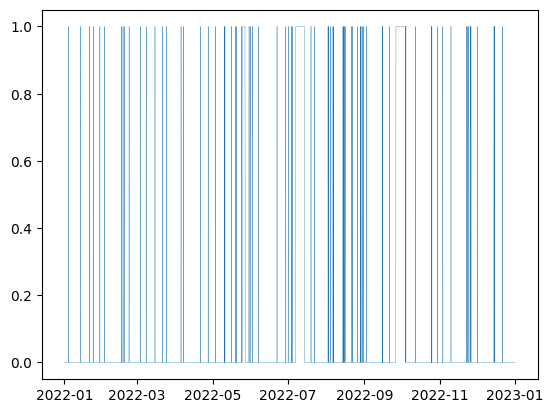

In [10]:
# air quality data:

# true/false value is assigned for each row (depending if no NaN values are found in the row, or at least one):
temp= df_raw_aq.isnull().any(axis=1)
# code true and false to 1 and 0, respectively:
temp[temp== True] = 1
temp[temp== False] = 0
plt.plot(df_raw_aq['times'], temp, linewidth=0.25)

Closer look revealed that the longest continuous gap in the data was a few days. Therefore we are confident in using linear interpolation (see discussion about different interpolation techniques [here](https://www.askpython.com/python/examples/interpolation-to-fill-missing-entries)): 

In [11]:
df_int_met= df_raw_met.copy()
df_int_aq= df_raw_aq.copy()
# meteorological data:
for col in df_int_met.columns:
    if (col != 'times'): # do not interplate time variable
        df_int_met[col]= df_int_met[col].interpolate()  
# air quality data:          
for col in df_int_aq.columns:
    if (col != 'times'): # do not interplate time variable
        df_int_aq[col]= df_int_aq[col].interpolate() 
# save the resulting dataframes in pickle format:
df_int_aq.to_pickle("./df_int_aq.pkl")  
df_int_met.to_pickle("./df_int_met.pkl")

We also note that the variables 'AQINDEX_PT1H_avg' (air quality index, see above) and 'n_man' (cloud cover) have types of category and integer, respectively. We change the variable types accordingly:

In [12]:
# read data:
df_int_met= pd.read_pickle("./df_int_met.pkl")  
df_int_aq= pd.read_pickle("./df_int_aq.pkl")  

# change feature types:
df_int_aq['AQINDEX_PT1H_avg']= df_int_aq['AQINDEX_PT1H_avg'].astype('category')
df_int_met['n_man']= df_int_met['n_man'].astype('int')

Next, we change the names of the columns to more informative ones. Also, we save the unit names to arrays. Finally, we save data column 'AQidx' as a separate array, because we will need this further on in the notebook. 

In [13]:
df_met= df_int_met.copy() # interpolated data
df_aq= df_int_aq.copy() # interpolated data
# column labels:
cols_met= ['time', 'T', 'W_vel', 'gW_vel', 'W_dir', 'RH', 'T_d', 'rain', 'rain_int', 'snow', 'P','vis', 'cloud']       
cols_aq= ['time', 'SO2', 'NO', 'NO2', 'O3', 'PM10', 'PM25', 'AQidx', 'BC']   
# units:
units_met= np.array(['C', 'm/s', 'm/s', 'deg', '%', 'C', 'mm', 'mm/h', 'cm', 'hPa', 'm', 'oktas']) # time excluded
units_aq= np.array(['µg/m3', 'µg/m3', 'µg/m3', 'µg/m3', 'µg/m3', 'µg/m3', 'µg/m3']) # time & AQidx excluded
# change column names:
df_met.columns= cols_met
df_aq.columns= cols_aq

# save the resulting dataframes:
df_aq.to_pickle("./df_aq.pkl")  # note : based on interpolated data
df_met.to_pickle("./df_met.pkl") # note : based on interpolated data

# save units:
with open('units.npy', 'wb') as f:
    np.save(f, units_met)
    np.save(f, units_aq)

# store feature 'air quality index' to a separate variable as well
AQidx= df_aq.AQidx
AQidx.to_pickle("./AQidx.pkl")

## 2. Data visualisation : visualising temporal trends in the data

We visualise the features as time series. In below, we show time-averaged (or [resampled](https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html)) values of the measured variables along with bands that show 95% [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval). Confidence intervals were calculated on the basis of [standard error of means](https://statisticsbyjim.com/hypothesis-testing/standard-error-mean/) and the time interval for averaging was 24 hours (daily data). 

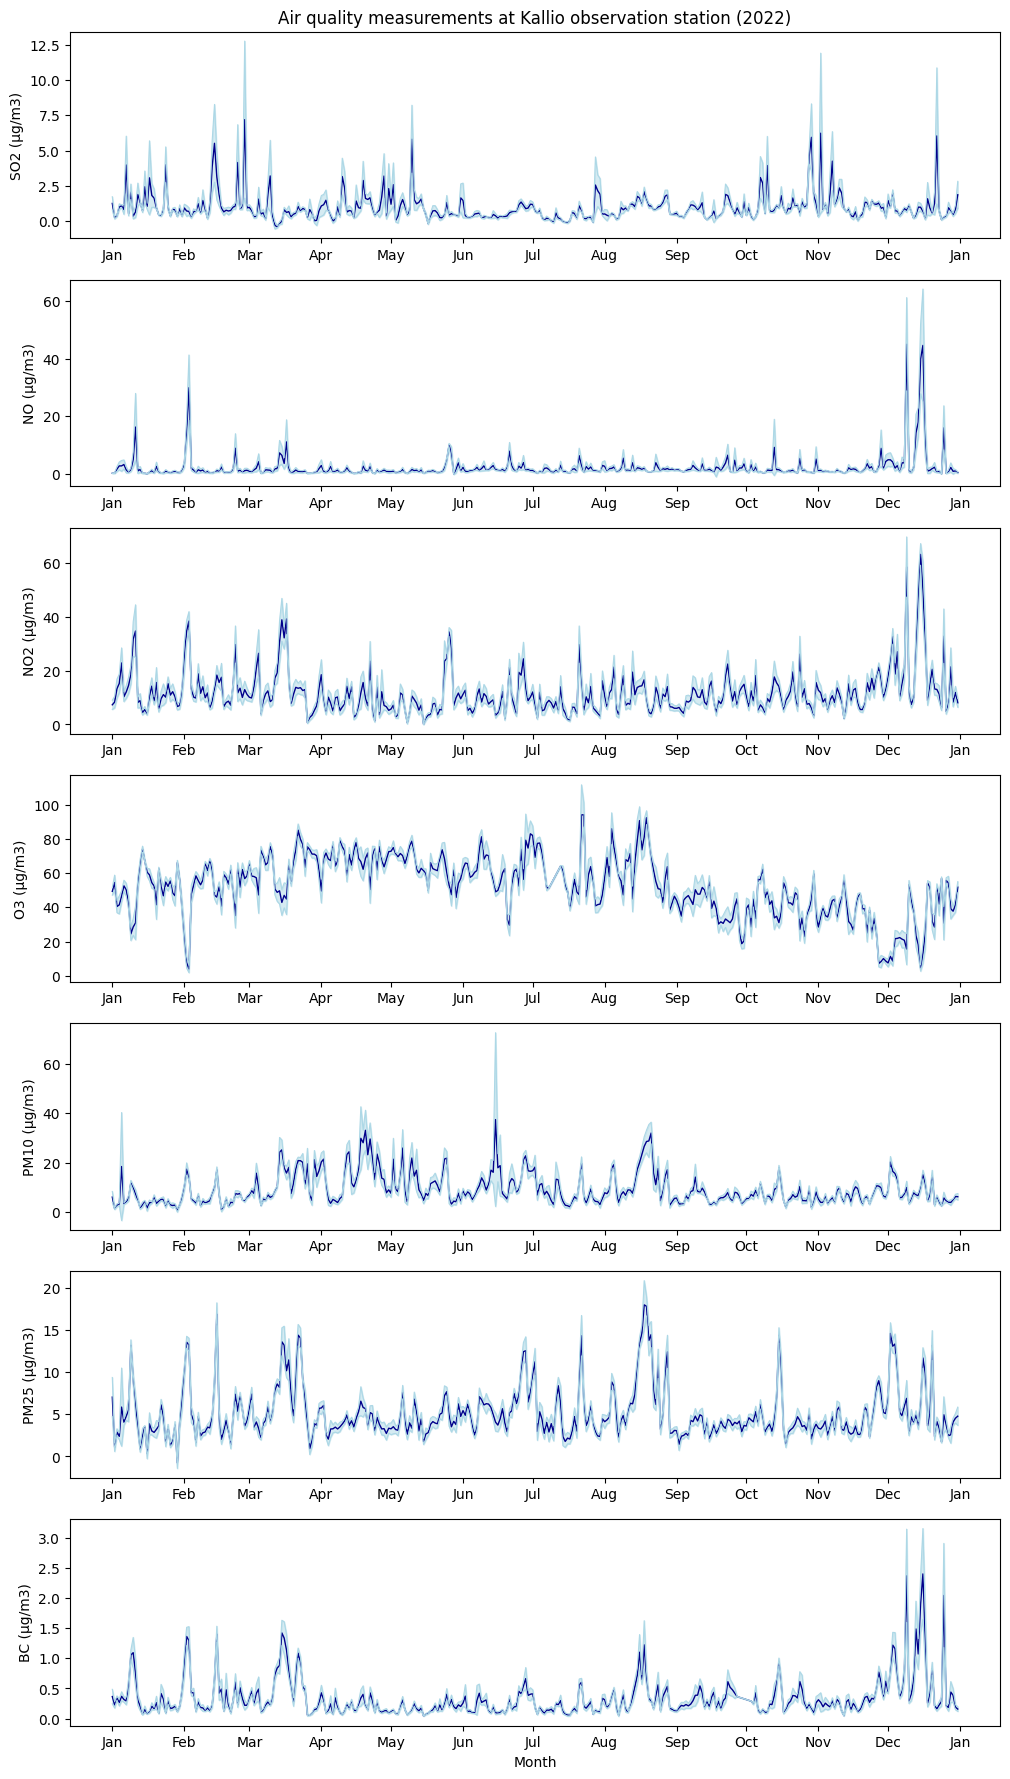

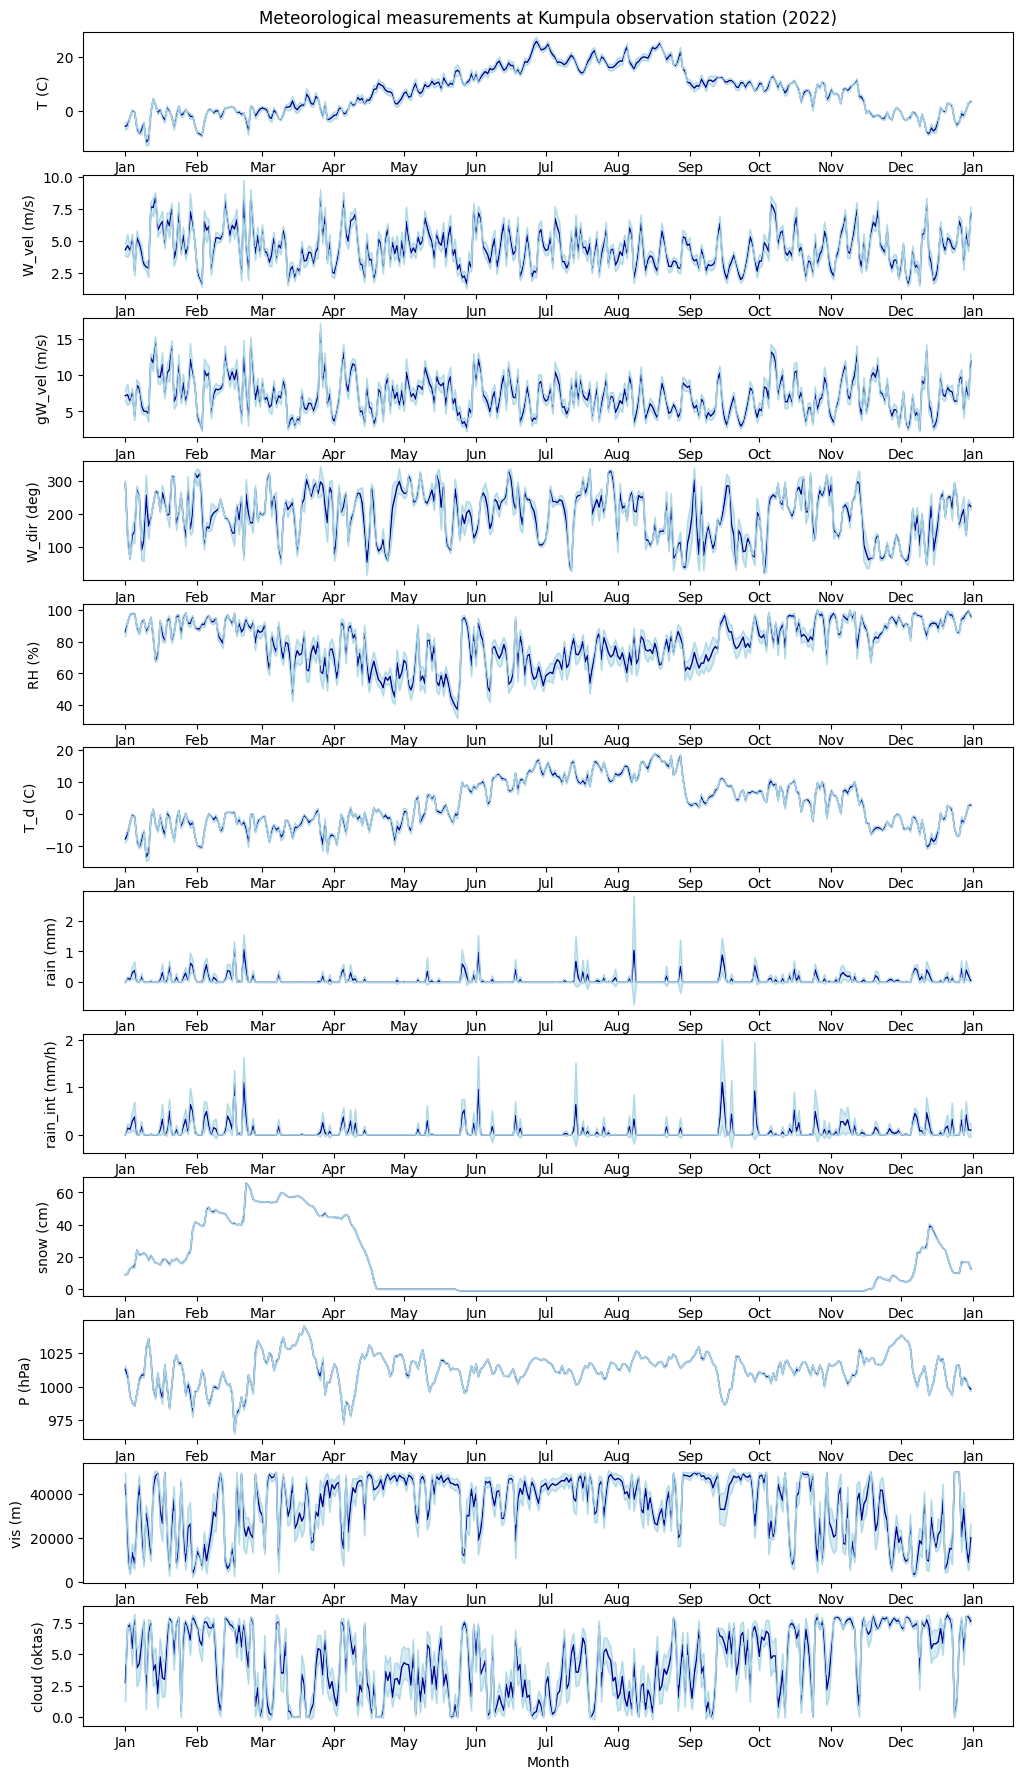

In [14]:
# Load data:
df_met= pd.read_pickle("./df_met.pkl")  # Meteorological data
df_aq= pd.read_pickle("./df_aq.pkl") # Air quality data
# units:  
with open('units.npy', 'rb') as f:
    units_met= np.load(f)
    units_aq= np.load(f)

# drop column representing air quality index (this is a categorical variable):
aq_data= df_aq.drop(columns=['AQidx']) 

# time averaged time series and confidence intervals (CI):
avg_interval = 'D' # averaging interval: daily

# air quality data:
aq_data_avg= aq_data.resample(avg_interval, on= 'time').mean() # avg
aq_data_sem= aq_data.resample(avg_interval, on= 'time').sem()  # standard error of the mean
delta= 1.96 * aq_data_sem # for 95% CI, assuming that sample is normally distributed
CI_aq_minus = (aq_data_avg - delta)
CI_aq_plus = (aq_data_avg + delta)

# meteorological data
met_data_avg= df_met.resample(avg_interval, on= 'time').mean() # avg
met_data_sem= df_met.resample(avg_interval, on= 'time').sem() # standard error of the mean
delta= 1.96 * met_data_sem # for 95% confidence intervals, assuming that sample is normally distributed
CI_met_minus = (met_data_avg - delta)
CI_met_plus = (met_data_avg + delta)

# following is used for formatting ticks:
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')

# display time series for air quality measurements:
fig_aq, ax_aq = plt.subplots(len(aq_data.columns)-1, 1, figsize=(12, 22))
idx= 0
for cols in (aq_data.drop(columns=['time'])).columns:
    a= sns.lineplot(ax=ax_aq[idx], data=aq_data_avg, x="time", y=cols, linewidth= 1.0, c= "darkblue")
    b= sns.lineplot(ax=ax_aq[idx], data=CI_aq_minus, x="time", y=cols, linewidth= .8, c="lightblue")
    c= sns.lineplot(ax=ax_aq[idx], data=CI_aq_plus, x="time", y=cols, linewidth= .8, c="lightblue")

    line = c.get_lines()
    # display the band showing confidence interval:
    ax_aq[idx].fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='lightblue', alpha=.5)    
    # format the ticks
    ax_aq[idx].xaxis.set_major_locator(months)
    ax_aq[idx].xaxis.set_major_formatter(months_fmt)
    # set label texts:
    ax_aq[idx].set_xlabel('')
    ax_aq[idx].set_ylabel(cols + " (" + units_aq[idx] + ")") 
    idx= idx+1

# set x-label to the bottom of the figure + title to the top
ax_aq[len(aq_data.columns)-2].set_xlabel("Month")
ax_aq[0].set_title("Air quality measurements at Kallio observation station (2022)")

# display time series for meteorological measurements:
fig_met, ax_met = plt.subplots(len(df_met.columns)-1, 1, figsize=(12, 22))
idx= 0
for cols in (df_met.drop(columns=['time'])).columns:
    #sns.lineplot(ax=ax_met[idx], data=df_met, x="time", y=cols, linewidth= 0.75)
    a= sns.lineplot(ax=ax_met[idx], data=met_data_avg, x="time", y=cols, linewidth= 1.0, c= "darkblue")
    b= sns.lineplot(ax=ax_met[idx], data=CI_met_minus, x="time", y=cols, linewidth= .8, c="lightblue")
    c= sns.lineplot(ax=ax_met[idx], data=CI_met_plus, x="time", y=cols, linewidth= .8, c="lightblue")

    line = c.get_lines()
    # display the band showing confidence interval:
    ax_met[idx].fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='lightblue', alpha=.5)    
    # format the ticks
    ax_met[idx].xaxis.set_major_locator(months)
    ax_met[idx].xaxis.set_major_formatter(months_fmt)
    # set the label texts
    ax_met[idx].set_xlabel('')
    ax_met[idx].set_ylabel(cols + " (" + units_met[idx] + ")") 
    idx= idx+1

# set x-label to the bottom of the figure + title to the top
ax_met[len(df_met.columns)-2].set_xlabel("Month")
ax_met[0].set_title("Meteorological measurements at Kumpula observation station (2022)")

# save the time-averaged data in Pickles format:
aq_data_avg.to_pickle("./aq_data_avg.pkl")  
met_data_avg.to_pickle("./met_data_avg.pkl")

### Correlations between features 

Next, we take a look at correlations between different measured variables using Seaborn package [heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html). We note that our approach to estimating correlations in case of time series is rather simplistic, and more sophisticated methods should be used in general (for example, stationarity of time series need to be checked, by using e.g. [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)). Here we use the time-averaged data calculated above.  

One aim of these considerations is to remove highly correlated features ([see this for motivation](https://towardsdatascience.com/why-exclude-highly-correlated-features-when-building-regression-model-34d77a90ea8e)).

<Figure size 1200x900 with 0 Axes>

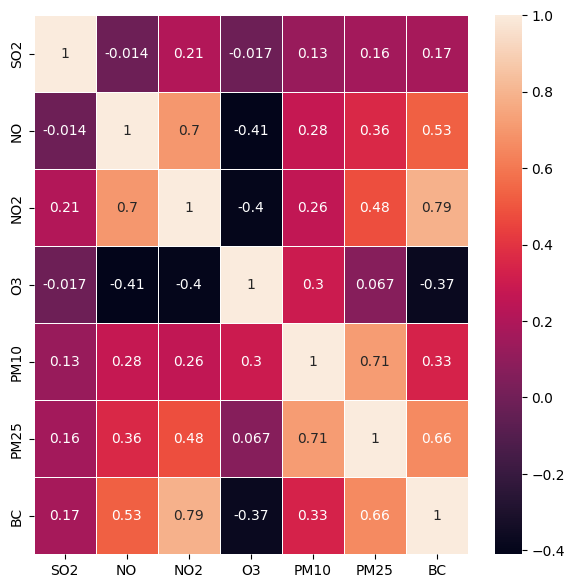

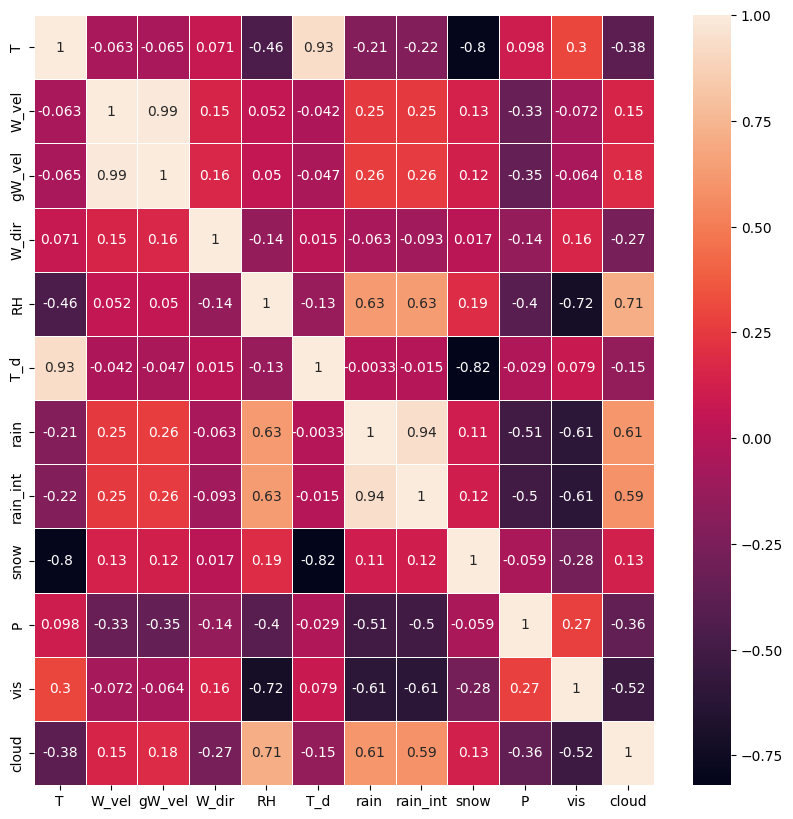

In [15]:
# load the time-averaged datasets:
aq_data_avg= pd.read_pickle("./aq_data_avg.pkl") 
met_data_avg= pd.read_pickle("./met_data_avg.pkl") 

# correlation tables:
corr_aq= aq_data_avg.corr(method='spearman')
corr_met= met_data_avg.corr(method='spearman')
# correlation heatmaps
plt.figure(figsize=(12, 9))
heat_aq = plt.figure(figsize=(7, 7))
sns.heatmap(corr_aq, annot=True, linewidths=0.4, annot_kws={'size': 10})
plt.show()
heat_met = plt.figure(figsize=(10, 10))
sns.heatmap(corr_met, annot=True, linewidths=0.4, annot_kws={'size': 10})
plt.show()

Let's take a look on the heat map for air quality data. Here we can spot two notable correlations, which are between NO & NO2, and between NO2 & BC. The former correlation is not really surprising due to atmospheric chemistry ([see this](https://en.wikipedia.org/wiki/NOx)). The latter correlation (NO2 and BC) is more interesting, however: it indicates that concentrations of black carbon (present in  aerosols) and NO2 concentrations are potentially linked with each other. Both of these can be considered as pollutants. So, could we attribute a physical cause for this correlation (traffic, for example)?. Also, the time series visualisation shown above indicates high, concurrent concentration peaks in NO, NO2, SO2, PM25 and BC for some days of December 2022. There could be a local pollution event (wood burning, roadworks?) which could also alone have some impact on the discussed correlation. This topic is not further pursued here, however.

From the heat map for the weather data we can spot prominent correlations between the following variable pairs: T & T_d, W_vel & gW_vel, and rain & rain_int. These correlations are not surprising because the variable pairs are related to the same phenomena (temperature, wind velocity and rain). Hence we drop the following variables from the meteorology data set: T_d, gW_vel, and rain_int.  

We also drop variable 'snow' because snow depth can be seen as being result of weather conditions which are in turn described by basic meteorological variables such as temperature, air pressure and RH.

Finally, we store the resulting data sets in Pickle format.

In [16]:
df_met.drop(columns=['T_d', 'gW_vel', 'rain_int', 'snow'], inplace= True)
met_data_avg.drop(columns=['T_d', 'gW_vel', 'rain_int', 'snow'], inplace= True)  # update time-averaged data as well
# store the data sets
df_met.to_pickle("./df_final_met.pkl")
df_aq.to_pickle("./df_final_aq.pkl")

In the following, we create dataframes (interpolated data + 24h time-averaged data) which contain data from both meteorological and air quality measurements. Also, we store the resulting dataframes in Pickle format. Finally, we store dataframe containing observed obserbed variables (which excludes air quality index) in Pickle format.

In [17]:
# Load data:
df_met= pd.read_pickle("./df_final_met.pkl")  # Meteorological data
df_aq= pd.read_pickle("./df_final_aq.pkl") # Air quality data

# combined data sets:
df_comb= pd.concat([df_met, df_aq], axis=1) # all data : meterology + air quality
comb_data_avg = pd.concat([met_data_avg, aq_data_avg], axis=1) # time-averaged measurement data
df_comb= df_comb.loc[:, ~df_comb.columns.duplicated()] # remove duplicate columns (= 'time' variable)

# save resulting dataframes: 
df_comb.to_pickle("./df_comb.pkl")  
comb_data_avg.to_pickle("./df_comb_data_avg.pkl")  

# set 'time' variable to be the index variable (we have time series data)
df_ts= df_comb.set_index('time')

# remove 'Aqidx' variable because it has type 'categorical'
# (other features have type of float/int, so no problems with normalization of those variables, see below)
df_ts.drop(columns=["AQidx"], inplace= True)

# save the resulting dataframe
df_ts.to_pickle("./df_ts.pkl")  


## 3. Unsupervised learning: data classification 

<p>Unsupervised learning is a part of machine learning (ML) techniques that can be used to find patterns in the data. The term 'unsupervised' comes from the fact that the models are not trained with human supervision. These techniques are especially useful when working with data sets that contains a large number of variables (which is the case for data considered here).</p> 

<p>The workflow for unsupervised learning is illustrated by the following figure:</p>  

![Unsupervised workflow](https://www.researchgate.net/profile/Patrick_Bours/publication/265985834/figure/fig1/AS:392169400619008@1470511879310/Unsupervised-Learning-Workflow-73_W640.jpg)

### Data classification: time series data

The following is more or less directly based on this [blog text](https://andrewm4894.com/2020/09/03/time-series-clustering-with-tslearn/) which illustrates use of clustering methods in case of time series data. In particular, we attempt to cluster the data based on features rather than on rows which represent single observations. Hence the use of transpose in the following codes.

In [18]:
# Load data:
df_comb= pd.read_pickle("./df_comb.pkl")  # combined time series data set (weather + air quality observations)
# df_comb_data_avg= pd.read_pickle("df_comb_data_avg.pkl") # time averaged (24h averaging interval) data for the dataset

#### Unsupervised learning: Data normalization

Before applying a clustering algorithm, we need to scale the numbers in the features to the same level. Otherwise, we end up comparing quantities which have different value ranges. The following two are among most commonly used options for data normalization: 

1) so-called [minMax method](https://tslearn.readthedocs.io/en/stable/gen_modules/preprocessing/tslearn.preprocessing.TimeSeriesScalerMinMax.html) which scales the numbers to range between 0-1.

2) scale the numbers with [MeanVariance](https://tslearn.readthedocs.io/en/stable/gen_modules/preprocessing/tslearn.preprocessing.TimeSeriesScalerMeanVariance.html#tslearn.preprocessing.TimeSeriesScalerMeanVariance) method so that the distribution of the numbers have mean of zero and their variance is unity.  

In the following, we use MeanVariance method, but by modifying code (see boolean variable 'preprocessing_meanvar' in the code below), one can toggle between MinMax and MeanVariance scaling method.  

In [19]:
# load dataframe used in below
df_ts= pd.read_pickle("./df_ts.pkl") 

# transpose the resulting dataframe (we are interested in clustering based on features)
X = df_ts.transpose().values

# data normalization:
preprocessing_meanvar= True # True : use MeanVariance scaling, False: use MinMax scaling 
if preprocessing_meanvar: # This scaler is such that each output time series has zero mean and unit variance
    X = TimeSeriesScalerMeanVariance().fit_transform(X)
    df_ts = pd.DataFrame(X.reshape(df_ts.shape), columns=df_ts.columns, index=df_ts.index)
else:
    X= TimeSeriesScalerMinMax().fit_transform(X) # Otherwise, we apply MinMax-normalization
    df_ts = pd.DataFrame(X.reshape(df_ts.shape), columns=df_ts.columns, index=df_ts.index)

After data scaling, we can then apply clustering algorithm to the data. In the following, we use algorithm based on [Dynamic Time Warping](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw.html) method which is suitable for clustering of time series data.  

The metrics we use for the evaluation of clustering results is so-called [silhoutte score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). For detailed  description of the silhoutte score, see [this Wikipedia page](https://en.wikipedia.org/wiki/Silhouette_(clustering)). To be brief, silhoutte score is a coefficient which varies between [+1, -1]. This gives us measure of distances between clusters, so that numbers close to +1 indicate that the object is well matched to its own cluster and poorly matched to neighboring clusters. In cases with silhoutte scores that are close to -1 on negative side, the score indicates that the resulting clusters overlap with each other.

Execution of the following code may take a while (for my setup, it took between two and three hours), so please be patient. The Dynamic Time Warping method used here also takes a good bit of memory, which may even cause abortion of the execution of the code (especially when using Colab). 

*Note:* the chosen model is stored using Pickle to a file named 'model_with_2_clusters.sav'. This should be included in the .zip package containing the project. Hence the following blocks can be skipped to part below [Clustering: results](###Clustering:-results).

In [20]:
# function for creating chosen clustering model: 
def create_model(n_clusters, X):
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, n_init=2).fit(X)
    return model

In [21]:
# We have 14 features in total, and we create cluster models for sizes (for the features) between sizes 2-7 in below.
n_c = range(2, 8) 

# Let us apply 'dtw' method (Dynamic Time Warping) for each cluster size:
kmeans = [create_model(i, X) for i in n_c]


In [22]:
# calculate metrics: 
silhouette_avg = [silhouette_score(X.reshape(df_ts.shape).transpose(), kmeans[i].labels_) for i in range(len(kmeans))]

# display metrics (silhoutte score for each cluster size):
k= 2 
for sil_avg in silhouette_avg:
    print("number of clusters: {}, silhouette score: {} ".format(k, round(sil_avg,2)))
    k= k + 1         

number of clusters: 2, silhouette score: 0.08 
number of clusters: 3, silhouette score: -0.01 
number of clusters: 4, silhouette score: -0.03 
number of clusters: 5, silhouette score: -0.12 
number of clusters: 6, silhouette score: -0.18 
number of clusters: 7, silhouette score: -0.18 


The applied clustering method for this data set does not produce clearly separate clusters (the silhoutte coefficients are around zero for all the considered cluster sizes). Nevertheless, we choose the clustering model with the largest positive silhouette coefficient value, and save the chosen model in Pickle format.

In [23]:
model= kmeans[0] # chosen clustering model (2 clusters, see code above)

 # save the chosen model to Pickle format
pickle.dump(model, open('model_with_2_clusters.sav', 'wb'))

### Clustering: results
Next we load the chosen model + time series data, and list the cluster numbers to which each feature in the data set belongs to.

In [24]:
# load the model
loaded_model = pickle.load(open('model_with_2_clusters.sav', 'rb'))
# load dataframe containing time series data 
df_ts= pd.read_pickle("./df_ts.pkl") 

# the following is more or less copy + paste from the blog text: 
# https://andrewm4894.com/2020/09/03/time-series-clustering-with-tslearn/
df_cluster = pd.DataFrame(list(zip(df_ts.columns, loaded_model.labels_)), columns=['feature', 'cluster'])

# display which feature belongs to which cluster: 
print(df_cluster.head(15))


   feature  cluster
0        T        1
1    W_vel        1
2    W_dir        1
3       RH        1
4     rain        0
5        P        1
6      vis        1
7    cloud        1
8      SO2        0
9       NO        0
10     NO2        0
11      O3        1
12    PM10        0
13    PM25        0
14      BC        0


To conclude with, we chose a model that classifies the features into two different clusters. As can be seen, meteorological variables (the first 8 variables in the list above) and air quality variables (the variables 8-14 in the list above) fall mostly into distinct clusters based on whether feature is related to meteorology or to air quality. Especially, features related to meteorology tend to fall into a cluster number 1. 

We can make the following _very_ loose interpretation of the results: weather conditions do not reflect air quality, or vice versa (for this data set). 

## 4. Supervised learning: predicting air quality index

In this section, our aim is to build ML model that can predict [air quality index](https://en.ilmatieteenlaitos.fi/air-quality-index) (this feature is included our data set), 'AQidx'. Note that this variable ('AQidx') is a categorical variable. In the following, we base our model on the air quality observation data set. This should be a trivial task, because air quality index is based on the measured air quality variables. The following can be thus seen as a exercise to check if our chosen ML method and its implementation works as it should.

Let us first plot the histogram illustrating the air quality index distribution (based on the raw data). 

Text(0, 0.5, 'Total number of counts')

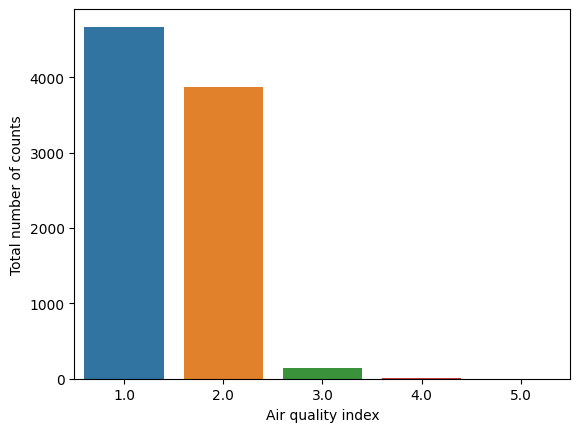

In [25]:
# plot histogram for the distribition of air quality indices
p = sns.countplot(x= df_raw_aq["AQINDEX_PT1H_avg"])
p.set_xlabel("Air quality index")
p.set_ylabel("Total number of counts")

The histogram shown above indicates that the air quality indices took values of 1 and 2 for most of the time. This means that the observed air quality was excellent (air quality index: 1) or good (air quality index: 2) for most of the time during the year of 2022. 

Let's then split the data into [training and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets). This is needed in case of supervised learning, where we train the model with a subset of data and then evaluate its performance based on a separate subset of data.

In [26]:
# Load air quality indices 
y= pd.read_pickle("./AQidx.pkl").astype('category')  

# Load air quality data:
df_aq= pd.read_pickle("./df_final_aq.pkl") 

# predictor variables (we use all the air quality variables, and drop the time variable):
X = df_aq.drop(columns= ['time'])

# split the data into training and testing tests: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


We use so-called [Decision Tree Regression](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) for our ML model. This is  done in below. 

In [27]:
# Train the decision tree classifier on the training data
clf_aq = DecisionTreeRegressor(random_state = 42)
clf_aq.fit(X_train, y_train)

# Predict the values for the test data
y_pred_aq = clf_aq.predict(X_test)


Next, we illustrate a comparison between ML model predictions and the test data. 

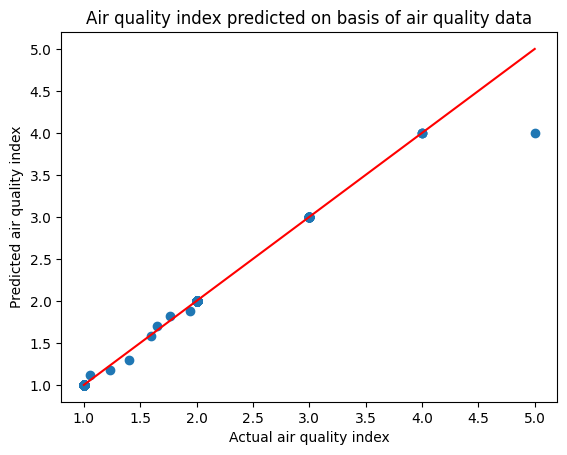

Correlation coeffient (between predictions and observations), as in R-squared:  0.9986660060996914
Root mean squared error:  0.019784325305393355


In [28]:
# Create a scatter plot of the predicted vs actual values
plt.scatter(y_test, y_pred_aq)
# seaborn.scatterplot(y_test, y_pred)

# Add labels and a diagonal line
plt.xlabel('Actual air quality index')
plt.ylabel('Predicted air quality index')
plt.plot([1, 5], [1, 5], color='red') # display 1:1 line
plt.title("Air quality index predicted on basis of air quality data")

# Show the plot
plt.show()

# display R2 metrics: 
r2 = r2_score(y_test, y_pred_aq)
print("Correlation coeffient (between predictions and observations), as in R-squared: ", r2)

# display RMSE: 
rmse = mean_squared_error(y_test, y_pred_aq, squared=False)
print("Root mean squared error: ", rmse)

Air quality index was predicted with high accuracy (as indicitated by R^2 score, of which value is practically unity). This is not really surprising result, as the air quality index (see [this](https://en.ilmatieteenlaitos.fi/air-quality-index)) is determined on the basis of certain air quality variables (that were included in the data set).   

At least, however, these results show that our implementation of the chosen ML model works as it should.   

Let us repeat the process above by using weather data instead of air quality data. 

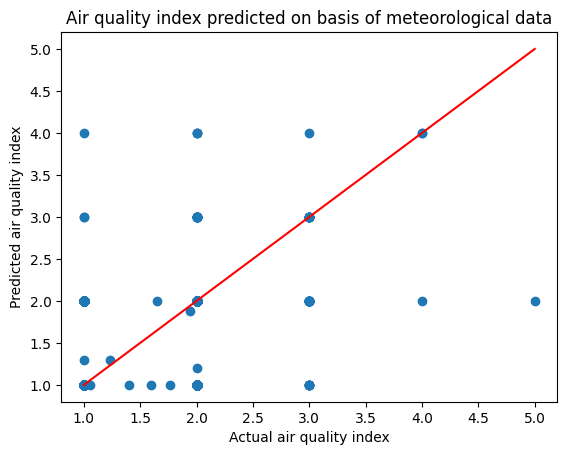

Correlation coeffient (between predictions and observations), as in R-squared:  0.050757797894195655
Root mean squared error:  0.5277555893502691


In [29]:
# load data:
df_met= pd.read_pickle("./df_final_met.pkl") 

# predictor variables (we use the meteorogical variables, and drop the time variable):
X = df_met.drop(columns= ['time'])

# split the data into training and testing tests: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the decision tree classifier on the training data
clf_met = DecisionTreeRegressor(random_state = 42)
clf_met.fit(X_train, y_train)

# Predict the values for the test data
y_pred_met = clf_met.predict(X_test)

# Illustrating results: 

# Create a scatter plot of the predicted vs actual values
plt.scatter(y_test, y_pred_met)

# Add labels and a diagonal line
plt.xlabel('Actual air quality index')
plt.ylabel('Predicted air quality index')
plt.plot([1, 5], [1, 5], color='red') # display 1:1 line
plt.title("Air quality index predicted on basis of meteorological data")

# Show the plot
plt.show()

# display R2 metrics: 
r2 = r2_score(y_test, y_pred_met)
print("Correlation coeffient (between predictions and observations), as in R-squared: ", r2)

# display RMSE: 
rmse = mean_squared_error(y_test, y_pred_met, squared=False)
print("Root mean squared error: ", rmse)

The results shown above indicate that the weather data cannot be used reliably to predict air quality (as indicated by the air quality index) for the considered data set.  

 One interesting question is the following: could we find a smaller set of features based on a combination of air quality/weather features to predict the air quality? In above, we developed only two separate ML models based on air quality/meteorology data sets. This would need further work, because it would take a lot of time as we would have to repeat ML predictions using several combinations (subsets) of features. Hence this topic is not pursued further here.

## 5. Summary

Air quality and weather data was downloaded from open data source (provided by Finnish Meteorological Institute). A set of data analysis techniques was used to visualise and analyse data. To summarize: 
- We did acquire data succesfully
- We did preprocess the data 
- We did visualise data (as in form of time series, and also using so-called heat map)
- We classified the resulting data based on a KMeans algorithm that is used for time series (which is the case here) 
- Model based on machine learning (ML) techniques were implemented to test if we can predict one of the features in the data set (so-called air quality index) based on the data sets. 

For the last part, our goal was to test the idea if we could use weather data to predict observed air quality conditions using ML techniques. The outcome of this exercise was that weather data cannot be used to predict with any accuracy the air quality (as measured with so-called air quality index). Further use of different various data analysis and machine learning techniques are needed to verify the conclusion.